In [76]:
import sys
sys.path.append("/Users/sucharitajayanti/Documents/W'20/CS 189 - Network Science and Complex Systems/finalProject/adversarial-epidemics/src")

In [77]:
import numpy as np
import pandas as pd
import networkx as nx
import itertools
import datapackage

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from simulator import SIRD, SIRDGraph
from preprocessing import airNet

In [78]:
def clean_up_data(G, D, string, default_val):
    missed = np.setdiff1d(list(G.nodes()), list(D.keys()))
    if(len(missed)):
        print("missing " + string + " for the following locations:")
        print(missed)
        for i in missed:
            D[i] = default_val
    return D

In [79]:
# Calculates what the weight should be on edge (n1,n2) n1!=n2
# Will get more complicated eventually

def get_edge_weight(base_weight, w_n1, w_n2):
    return base_weight

In [80]:
def get_graph_with_labels(G, pop_dict, node_wreg, spread_rate, mortality_rate, recovery, infected, pos, max_weight):
    
    pop_dict = clean_up_data(G, pop_dict, "populations", 0)
    node_wreg = clean_up_data(G, node_wreg, "weight regulations", 1)
    spread_rate = clean_up_data(G, spread_rate, "b (spread rate)", 0)
    mortality_rate = clean_up_data(G, mortality_rate, "w (mortality rate)", 0)
    recovery = clean_up_data(G, recovery, "k (recovery)", 0.5)
    infected = clean_up_data(G, infected, "i (% initially infected)", 0)
    pos = clean_up_data(G, pos, "positions", (0,0))
    
    max_weight = max_weight + 0.0000000001

    nodes = [(n, SIRD(b=spread_rate[n], k=recovery[n], w=mortality_rate[n], N=pop_dict[n], i=infected[n]), pos[n]) for n in list(G.nodes())] 
    edges = [(u,v,get_edge_weight(d['weight'], node_wreg[u], node_wreg[v])/max_weight) for (u,v,d) in G.edges(data=True)]
    
    return nodes, edges
       

In [81]:
def get_name_alpha3_conv():
    l_data = pd.read_csv('../../data/SIRDNMetrics/Abrevs.csv')
    code_dict = {l_data['Country'][i]: l_data['Alpha3Code'][i] for i in range(l_data.shape[0])}  
    return code_dict

In [82]:
# POPULATION DATA RETRIEVAL

def get_pop_data(year):
    p_data = pd.read_csv('../../data/SIRDNMetrics/Population.csv')
    
    code_dict = get_name_alpha3_conv()
    
    label = 'Year_' + str(year)
    df = p_data[['Country_Code',label]]
    pop_code_dict = {}
    for i in range(df.shape[0]):
        pop_code_dict[df.iloc[i][0]] = df.iloc[i][1]
    
    pop_dict = {}
    for loc in code_dict:
        if code_dict[loc] in pop_code_dict:
            pop_dict[loc] = pop_code_dict[code_dict[loc]]
            
    return pop_dict


In [83]:
# NODE POSITION DATA RETRIEVAL

# HELPER FUNCTION
# Gets country coordinates (latitude, longitude)
# Uses coords, hScale, vScale, hShift and vShift to find positions for the nodes
def get_pos_dict(hScale, vScale, hShift, vShift):
    pos_data = pd.read_csv('../../data/SIRDNMetrics/Location.csv')
    pos = {pos_data['Country'][i]:(pos_data['Longitude'][i] * hScale + hShift, pos_data['Latitude'][i] * vScale + vShift) for i in range(pos_data.shape[0])}
    return pos

# Calculates country positions from scratch
# (0,0) at the top left corner
def get_pos_data():
    world_map=mpimg.imread('../../data/SIRDNMetrics/worldMap.png')
    map_dim = world_map.shape
    
    pos_dict = get_pos_dict(map_dim[1]/360, -1*map_dim[0]/240, map_dim[1]/2, map_dim[0]/2 + 300)
    
    return pos_dict


In [84]:
# TEMP HACK FUNCTION FOR OTHER DATA RETRIEVAL

def temp_create_data(G, pop_dict, max_weight):
    node_wreg = {k:1 for k in pop_dict}
    spread_rate = {k:0.5 for k in pop_dict}
    mortality_rate = {k:0.1 for k in pop_dict}
    recovery = {k:0.8 for k in pop_dict}
    infected = {k:0 for k in pop_dict}
    infected["Germany"] = 1
    infected["Canada"] = 8
    infected["Singapore"] = 20 
    infected["Hong Kong"] = 95
    infected["Switzerland"] = 2
    infected["Thailand"] = 1
    infected["Vietnam"] =  40
    infected["China"] = 100

    percent_infected = {n:infected[n]/pop_dict[n] for n in infected}    
    return pop_dict, node_wreg, spread_rate, mortality_rate, recovery, infected, percent_infected


## Graph Generation Code ##

In [85]:
def get_SIRDN_graph():
    G, max_weight = airNet.generate_country_graph()
    pop_dict = get_pop_data(2003)#pop_dict_year(get_pop_data(), 2003)
    pos = get_pos_data()
    #TEMP HACK
    pop_dict, node_wreg, spread_rate, mortality_rate, recovery, infected, percent_infected =  temp_create_data(G, pop_dict, max_weight)
    
    # Generate SIRDN graph
    n, e = get_graph_with_labels(G, pop_dict, node_wreg, spread_rate, mortality_rate, recovery, percent_infected, pos, max_weight)
    return n, e, G, pos


## Visualization Code ##

In [86]:
# Visualization Helper
def plot_world_map(w=180, h=160):
    fig=plt.figure(figsize=(w, h))
    world_map=mpimg.imread('../../data/SIRDNMetrics/worldMap.png')
    plt.imshow(world_map)
    
# takes nodes, returns nodes->labels dict
# sanatizes label list in between if necessary
def get_labels(nodes):
    code_dict = get_name_alpha3_conv()
    
    labels = {}
    for n in nodes:
        if n in code_dict:
            labels[n] = code_dict[n]
        else:
            labels[n] = 'N/A'

    return labels


## Testing Code ##

In [87]:
n, e, G, pos = get_SIRDN_graph()

missing populations for the following locations:
['American Samoa' 'Anguilla' 'British Virgin Islands' 'Burma'
 'Christmas Island' 'Cocos (Keeling) Islands' 'Cook Islands' 'East Timor'
 'Falkland Islands' 'Faroe Islands' 'French Guiana' 'French Polynesia'
 'Guadeloupe' 'Guam' 'Guernsey' 'Jersey' 'Martinique' 'Mayotte'
 'Netherlands Antilles' 'New Caledonia' 'Niue' 'Norfolk Island'
 'Northern Mariana Islands' 'Puerto Rico' 'Reunion'
 'Saint Pierre and Miquelon' 'Taiwan' 'Turks and Caicos Islands'
 'Virgin Islands' 'Wallis and Futuna' 'Western Sahara']
missing weight regulations for the following locations:
['American Samoa' 'Anguilla' 'British Virgin Islands' 'Burma'
 'Christmas Island' 'Cocos (Keeling) Islands' 'Cook Islands' 'East Timor'
 'Falkland Islands' 'Faroe Islands' 'French Guiana' 'French Polynesia'
 'Guadeloupe' 'Guam' 'Guernsey' 'Jersey' 'Martinique' 'Mayotte'
 'Netherlands Antilles' 'New Caledonia' 'Niue' 'Norfolk Island'
 'Northern Mariana Islands' 'Puerto Rico' 'Reunion'


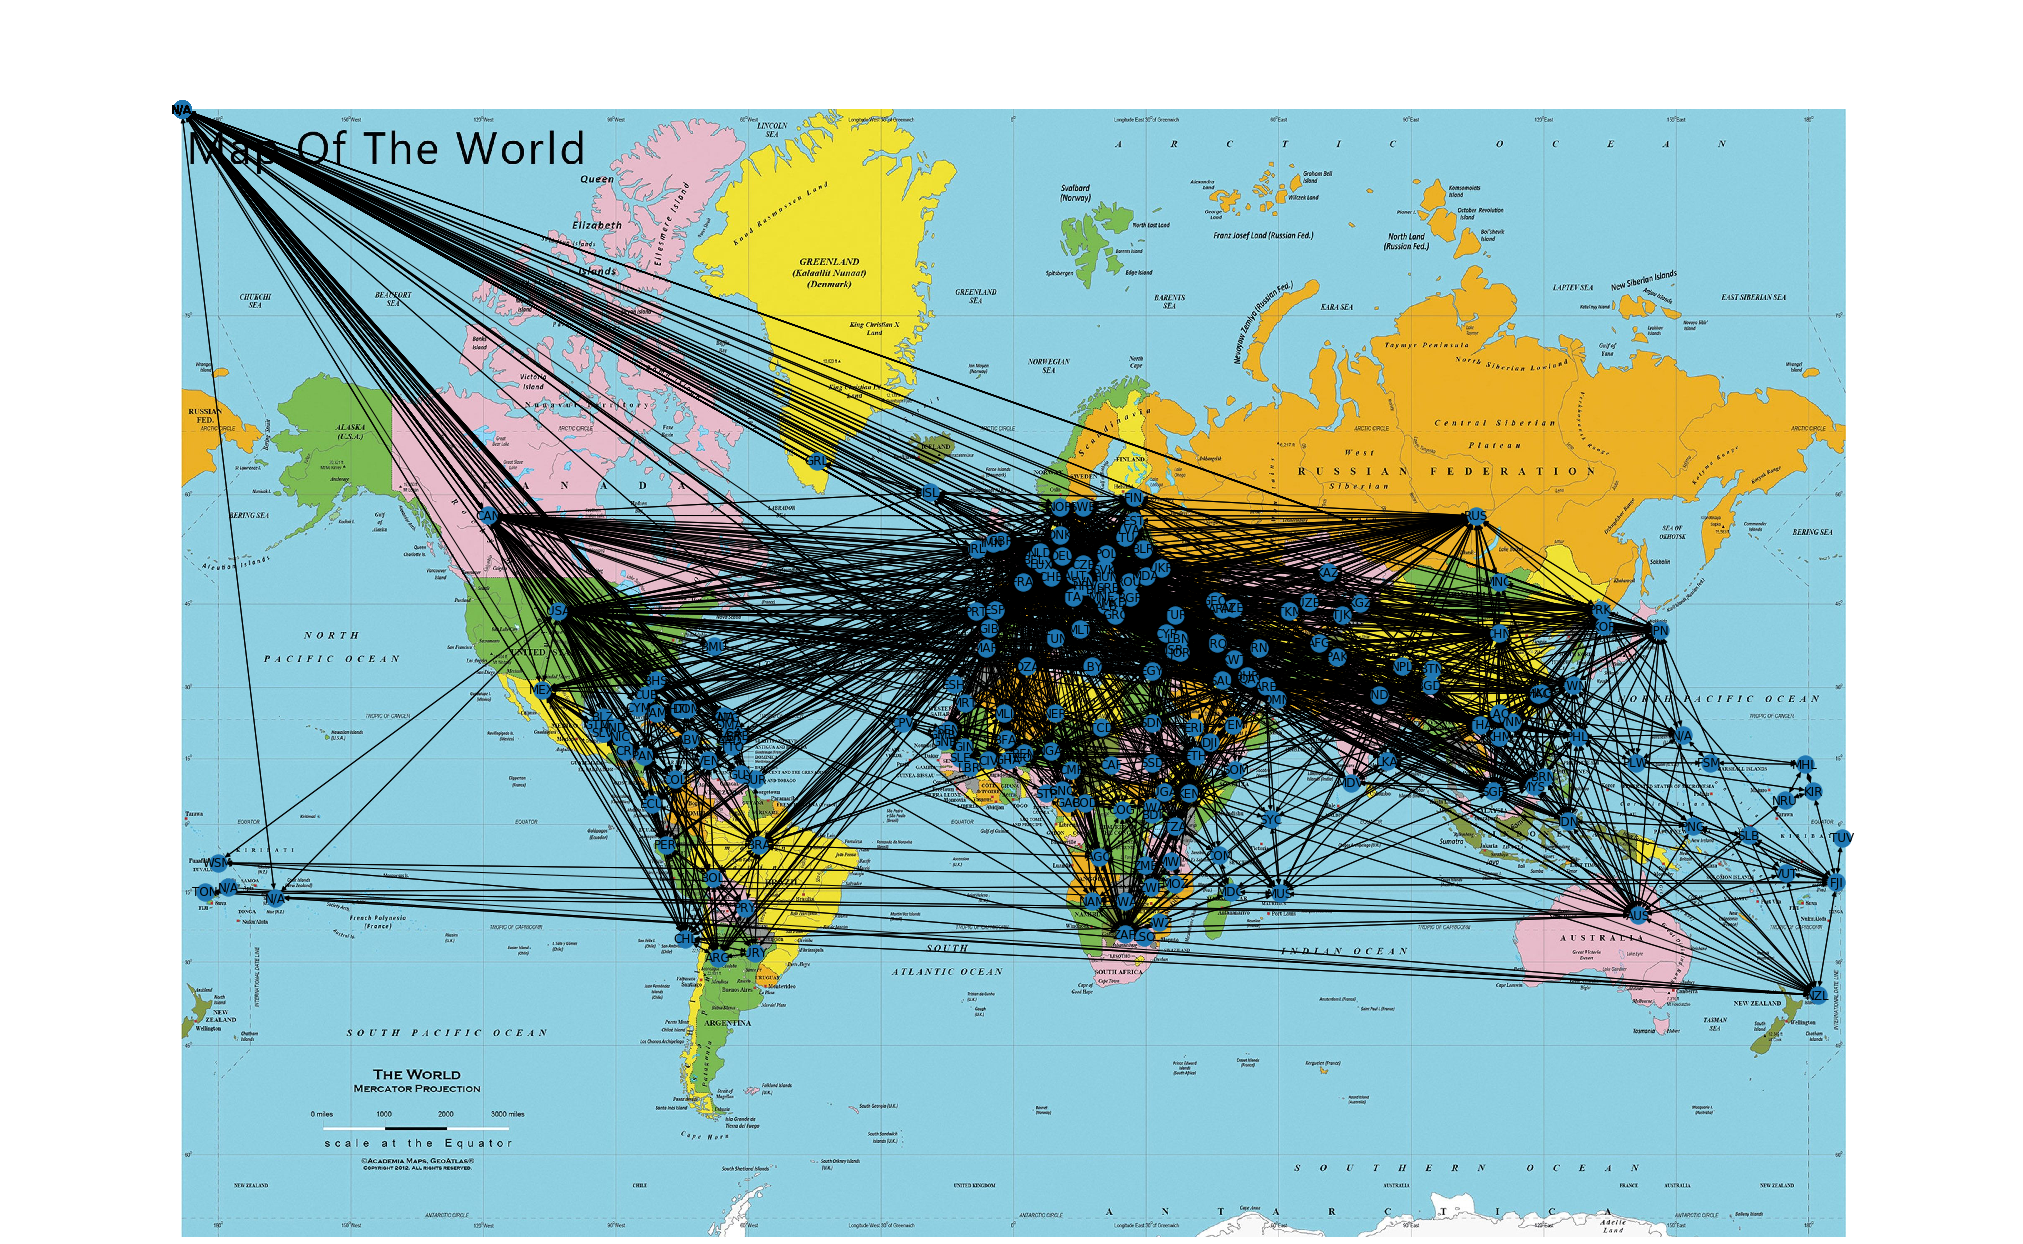

In [88]:
plot_world_map(36, 32)
nx.draw(G, with_labels=True, labels = get_labels(list(G.nodes())), pos=pos)
plt.savefig('./test.png')